In [1]:
import os
import pkg_resources
pkg_resources.require("numpy>=`1.20.1")  #  to use specific numpy version
import numpy as np
import rsnapsim as rss
import sys
from sys import platform
from skimage import io ; from skimage.io import imread; from skimage.measure import find_contours
from random import randrange
import pandas as pd
import os; from os import listdir; from os.path import isfile, join
import re
import shutil
import pathlib
from random import randrange
import ipywidgets as widgets ; from ipywidgets import interact, interactive, fixed, interact_manual, Button, HBox, VBox, Layout, GridspecLayout 
from IPython.display import Image
import dna_features_viewer
from dna_features_viewer import BiopythonTranslator, GraphicFeature, GraphicRecord, CircularGraphicRecord


In [14]:
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['font.size'] = 15
plt.rcParams['axes.grid'] = False

In [3]:
# Deffining directories
current_dir = pathlib.Path().absolute()
sequences_dir = current_dir.parents[1].joinpath('DataBases','gene_files')
video_dir = current_dir.parents[1].joinpath('DataBases','videos_for_sim_cell')
rsnaped_dir = current_dir.parents[1].joinpath('rsnaped')

In [4]:
# Importing rSNAPsim_IP
sys.path.append(str(rsnaped_dir))
import rsnaped as rsp

In [5]:
gene_file_pUB_SM_KDM5B_PP7 = str(sequences_dir.joinpath('pUB_SM_KDM5B_PP7.gb'))
gene_file_pUB_SM_p300_MS2 = str(sequences_dir.joinpath('pUB_SM_p300_MS2.gb'))

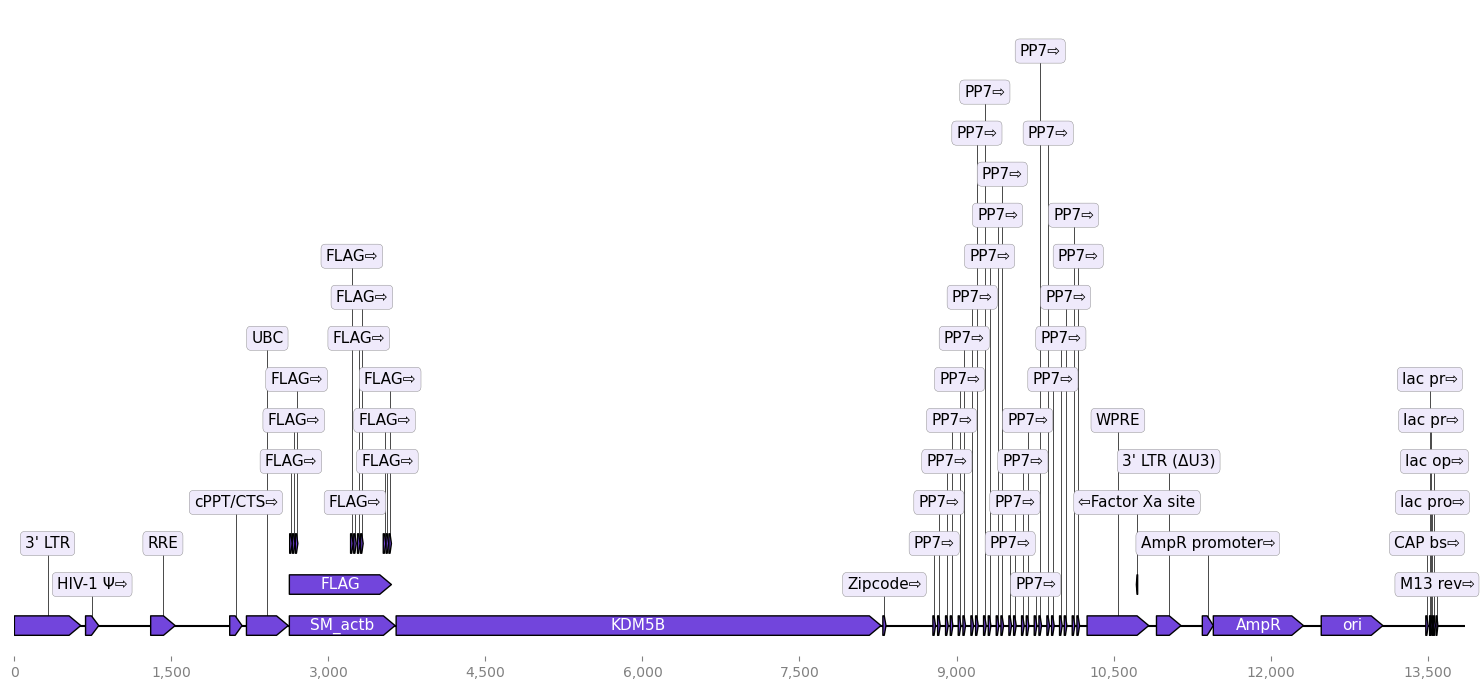

In [17]:
plt.style.use('default')
graphic_record = BiopythonTranslator().translate_record(gene_file_pUB_SM_KDM5B_PP7) #, record_class=CircularGraphicRecord
ax, _ = graphic_record.plot(figure_width=15, strand_in_label_threshold=15)
ax.figure.tight_layout()
#ax.figure.savefig("from_genbank.png")


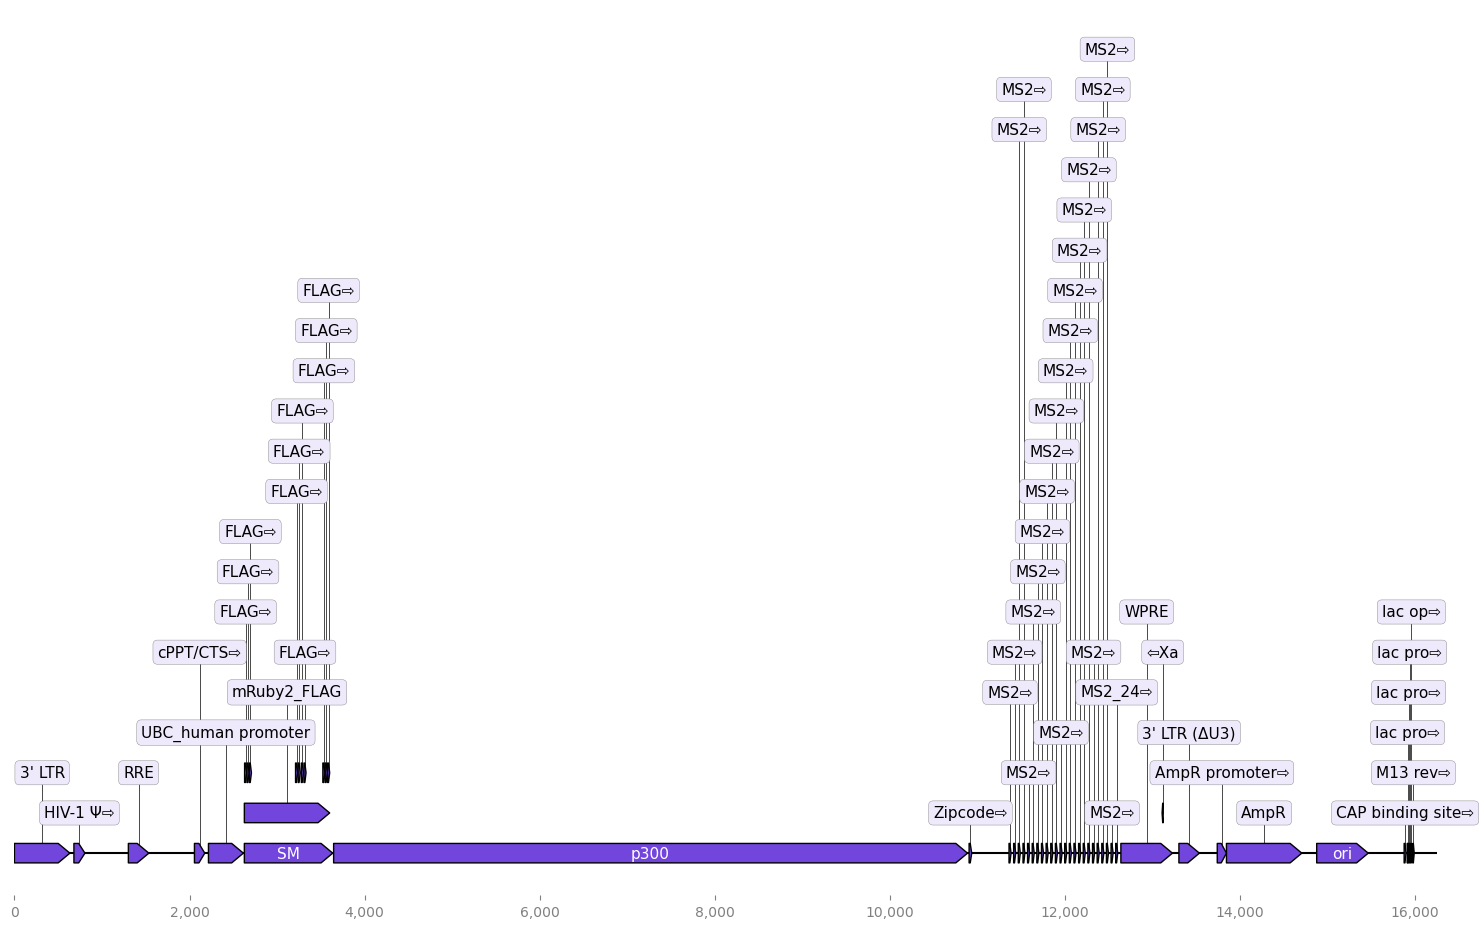

In [19]:
graphic_record = BiopythonTranslator().translate_record(gene_file_pUB_SM_p300_MS2) #, record_class=CircularGraphicRecord
ax, _ = graphic_record.plot(figure_width=15, strand_in_label_threshold=10)
ax.figure.tight_layout()
#ax.figure.savefig("from_genbank.png")

In [ ]:
gene_file_KDM5B_PP7 = str(sequences_dir.joinpath('pUB_SM_KDM5B_PP7_coding_sequence.txt'))
gene_file_p300_MS2 = str(sequences_dir.joinpath('pUB_SM_p300_MS2_coding_sequence.txt'))

In [8]:
raise

RuntimeError: No active exception to reraise

In [ ]:
list_files_names = sorted([f for f in listdir(video_dir) if isfile(join(video_dir, f)) and ('.tif') in f], key=str.lower)  # reading all tif files in the folder
list_files_names.sort(key=lambda f: int(re.sub('\D', '', f)))  # sorting the index in numerical order
path_files = [ str(video_dir.joinpath(f).resolve()) for f in list_files_names ] # creating the complete path for each file
num_cell_shapes = len(path_files)

In [ ]:
plt.plot([1,1])